# ***Machine Learning-Driven Ad Blocking: From Data Collection to Deployment***

## 1 Prerequisites

### 1.1 Installing requirements

This code has been tested and is supposed to run correctly with Python 3.7 and the following libraries' versions:

* [orjson==3.4.3](https://github.com/ijl/orjson)
* [tensorflow==2.3.1](https://www.tensorflow.org/)





In [ ]:
#Upgrading pip
!pip install --upgrade pip

In [ ]:
#Installing requirements
!pip install orjson==3.4.3
!pip install tensorflow==2.3.1

### 1.2 Downloading data

In [ ]:
!wget https://storage.googleapis.com/www21/data.zip

In [ ]:
!unzip data.zip

[link text](https://)## 2 Looking at the data

### 2.1 Preparing data-related tasks

So far, we downloaded a sample dataset, where each graph is represented by a `JSON`. To run statistics on this we need to first load the dataset.

Each `JSON` has the following structure:


```json
{
  "type": "ml.dom",
  "url": <The url where the DOM was extracted from>,
  "isIFrame": <Whether this DOM tree was associated with an IFrame or not>,
  "graph": {
    "tag": <String, The HTML tag associated with the node>,
    "ad": <0/1, Whether this node is part of an ad or not>,
    "attributes": <Dictonary of the nodes' CSS attributes>,
    "filter": <The filter that matched this node, if applicable>,
    "elementHidden": <Whether this node matched a hiding filter or not>,
    "elementBlocked": <Whether this node matched a blocking filter or not>,
    "height": <Height of the HTML element>,
    "width": <Width of the HTML element>,
    "children": <List of nodes that branch off this node>
  }
}
```



In [ ]:
# Importing relevant libraries
import pathlib
import orjson
import typing
import gzip
import itertools

In [ ]:
def get_data(
    dataset_path: typing.Type[pathlib.Path], 
    filter: typing.Optional[typing.Callable[[dict], bool]] = lambda x: True
    ) -> typing.Iterable:
  all_files = dataset_path.glob('*.gz')
  dataset = []

  for f in all_files:

    with gzip.open(f, mode='r') as stream:
      try:
        data = orjson.loads(stream.read())
      except BaseException:
        # This usually means that the data file is somehow corrupted.
        # For the purpose of this tutorial, we'll skip these.
        continue
      
      if 'graph' not in data:
        # The JSON does not have the expected format, so we'll just 
        # ignore this for now.
        continue
      
      if not filter(data):
        # The graph did not pass the filter function, so we'll ignore
        # this one as well.
        continue
      
    yield data    


In [ ]:
dataset_path = pathlib.Path('data')
graphs = get_data(dataset_path)

### 2.2 Looking at what we're working with

First, let's take a look at some basic information about our dataset:


* How many webpages we have in this dataset
* What domains the webpages come from
* How many of the graphs are iFrames
* How big these webpages are
* Our label distribution (`ad` vs `not-ad`)



In [ ]:
import urllib.parse as urlparse

In [ ]:
ad_count = 0
not_ad_count = 0
iframes_count = 0
domains = {}

In [ ]:
def get_label_distribution(node: typing.Dict):
  global ad_count
  global not_ad_count

  if node['ad']:
    ad_count += 1
  else:
    not_ad_count += 1

  for child in node['children']:
    get_label_distribution(child)  

In [ ]:
# Re-initialising all constants
total_graphs = 0
ad_count = 0
not_ad_count = 0
iframes_count = 0
domains = {}


for graph in graphs:
  if graph['isIFrame']:
    iframes_count += 1
  
  domain = urlparse.urlparse(graph['url']).netloc
  if domain in domains:
    domains[domain] += 1
  else:
    domains[domain] = 1
  
  total_graphs += 1
  get_label_distribution(graph['graph'])

total_nodes = ad_count + not_ad_count

In [ ]:
print("Number of web pages: {}".format(total_graphs))
print("iFrames: {} ({:.2f}%)".format(iframes_count, iframes_count/total_graphs * 100))

In [ ]:
print("Domains: {}".format(list(domains.keys())))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

domains_list = list(domains.keys())
counts = [domains[d] for d in domains_list]
y_pos = np.arange(len(domains_list))

plt.bar(y_pos, counts, align="center")
plt.xticks(y_pos, domains_list, rotation=45)
plt.ylabel('Number of webpages')
plt.xlabel('Domain')
plt.title('Domain distribution')

plt.show()

In [ ]:
print("Total number of nodes: {}".format(total_nodes))
print("Average graph size: {:.2f} nodes".format((total_nodes/total_graphs)))
print("Ads: {} ({:.2f}%)".format(ad_count, ad_count / total_nodes * 100))
print("Not ads: {} ({:.2f}%)".format(not_ad_count, not_ad_count / total_nodes * 100))

Let's look at how what HTML tags we have in our dataset



In [ ]:
# Defining global variables
tag_dist = {}
tag_dist_ads = {}
tag_dist_not_ads = {}

In [ ]:
def update_dict(key: str, d: dict):
  if key in d:
    d[key] += 1
  else:
    d[key] = 1

In [ ]:
def get_tag_distribution(node: dict):
  global tag_dist
  global tag_dist_ads
  global tag_dist_not_ads

  tag = node['tag'].upper()
  update_dict(tag, tag_dist)

  if node['ad']:
    update_dict(tag, tag_dist_ads)
  else:
    update_dict(tag, tag_dist_not_ads)

  for child in node['children']:
    get_tag_distribution(child)

In [ ]:
# Re-loading the dataset
graphs = get_data(dataset_path)

# Re-initialising counters
tag_dist = {}
tag_dist_ads = {}
tag_dist_not_ads = {}

# Traversing the dataset
for graph in graphs:
  get_tag_distribution(graph['graph'])

In [ ]:
print('Number of different tags: {}'.format(len(list(tag_dist.keys()))))
print('Number of different tags for `ads`: {}'.format(len(list(tag_dist_ads.keys()))))
print('Number of different tags for `not ads`: {}'.format(len(list(tag_dist_not_ads.keys()))))

We can see that we have quite a few different tags to look at.

In order to visualise this better, we'll look at the 10 most frequent tags and how they are distributed.

In [ ]:
# Getting the top 10 tags
tags_list = [(key, value) for key, value in tag_dist.items()]
sorted_tags_list = sorted(tags_list, key=lambda item: item[1], reverse=True)
top_10_tags = [item[0] for item in sorted_tags_list[:10]]
top_10_tags

In [ ]:
# Tags distribution for the entire dataset
top_10_tags_counts = [tag_dist[tag] for tag in top_10_tags]
y_pos = np.arange(10)

plt.bar(y_pos, top_10_tags_counts, align='center')
plt.xticks(y_pos, top_10_tags)
plt.title('Tags distribution in the entire dataset')
plt.xlabel('Tag')
plt.ylabel('Tag count')

plt.show()

Now, let's look at how the tags are distributed for ad and not-ad nodes, specifically and see if we can notice any difference

In [ ]:
# Tags distribution for ad nodes

# TODO: Plot a bar chart with the top 10 tag counts for ad nodes

In [ ]:
# Tags distribution for not-ad nodes

# TODO: Plot a bar chart with the top 10 tag counts for not-ad nodes

### 2.3 Filtering the dataset at load time

In the definition of the `get_data` function above, we added a `filter` attribute that can be used to filter data at load-time.

This is expected to be a function that takes a graph as argument and returns:


*   **True** if the item should be loaded
*   **False** if it should be dropped



From the initial statistics we ran on this dataset, we noticed that we are working with a few IFrames. Let's look at a simple filter that ignores these graphs.

In [ ]:
def iframe_filter(graph: dict) -> bool:
  if graph['isIFrame']:
    return False
  
  return True

In [ ]:
no_iframes_data = get_data(dataset_path, filter=iframe_filter)

graphs_count = sum(1 for _ in no_iframes_data)
print('Number of graphs loaded: {}'.format(graphs_count))

Now, let's move on to something a little more complex - filtering by domain, let's say `www.nytimes.com`

In [ ]:
def domain_filter(graph: dict) -> bool:
  # TODO: Add logic here so that we only get
  # graphs from `www.nytimes.com`

  return False

In [ ]:
domain_filtered_data = get_data(dataset_path, filter=domain_filter)

graphs_count = sum(1 for _ in domain_filtered_data)
print('Number of graphs loaded: {}'.format(graphs_count))

## 3 Data conversion

Machine Learning models require a set of vectors as input, we cannot feed them the data in JSON format and expect this to work.

In this section, we will look at how we can convert the each graph into:

*   **An adjacency matrix** - encoding the way nodes are connected to each other in the graph
*   **Features matrix** - where we store information about each node
* **Vector of labels** - showing whether a node is an ad or not.




First, let's define a dummy graph that we can test this on, so we don't have to load the dataset every time

In [ ]:
test_graph = {
    'isIFrame': False,
    'url': 'https://test.com',
    'type': 'ml.dom',
    'graph': {
        'tag': 'BODY',
        'ad': False,
        'elementHidden': False,
        'elementBocked': False,
        'filter': None,
        'height': 3151,
        'width': 624,
        'requestType': None,
        'attributes': {},
        'children': [
            {
              'tag': 'DIV',
              'ad': True,
              'elementHidden': True,
              'elementBlocked': False,
              'filter': 'some-filter',
              'height': 2000,
              'width': 300,
              'requestType': None,
              'attributes': {
                  'display': 'none',
              },
              'children': [], 
            },
            {
              'tag': 'A',
              'ad': False,
              'elementHidden': False,
              'elementBlocked': False,
              'height': 1000,
              'width': 300,
              'requestType': None,
              'attributes': {
                  'src': 'https://www.some-website.com',
                  'display': 'inline',
              },
              'children': [], 
            },
        ],
    },
}

### 3.1 Getting the adjacency matrix

For the test graph defined above we expect the **undirected** adjacency matrix to look something like this:

$$
\begin{pmatrix}
0 & 1 & 1\\
1 & 0 & 0\\
1 & 0 & 0
\end{pmatrix}
$$

First, we need to find the graph size.

In [ ]:
def get_graph_size(node: dict) -> int:
  lower_level_nodes = 0

  for child in node['children']:
    lower_level_nodes += get_graph_size(child)
  
  return lower_level_nodes + 1

In [ ]:
test_graph_size = get_graph_size(test_graph['graph'])
test_graph_size

Now, we can go ahead and actually compute the adjacency matrix for this graph.

In [ ]:
import numpy as np

In [ ]:
adjacency_matrix = np.array([np.zeros(test_graph_size, dtype=np.int) for _ in range(test_graph_size)])

In [ ]:
def construct_adjacency_matrix(node: dict, node_id: int, parent_id: int) -> int:
  max_node_id = node_id + 1
  node['id'] = node_id

  if parent_id is not None:
    adjacency_matrix[node_id][parent_id] = 1

  for child in node['children']:
    max_node_id = construct_adjacency_matrix(child, max_node_id, node_id)
    adjacency_matrix[node_id][child['id']] = 1
 
  return max_node_id


In [ ]:
construct_adjacency_matrix(test_graph['graph'], 0, None)

Now, let's see if we get what we were expecting

In [ ]:
print(adjacency_matrix)

### 3.2 Extracting features


We are working with a lot of information, so feature selection is a key step in developing our models. In this section, we'll look into what kind of features we considered and how we can extract them from our raw dataset

#### 3.2.1 Node id

Perhaps one of the most straight-forward feature one can extract, `node_id` is simply a unique value associated to each node. In this case, we'll have this as an integer, the nodes' order being given by running the DFS algorithm through the tree.

As a matter of fact, we are already extracted this `node_id` when constructing the adjacency matrix and assigned them to the respective node. Let's try to get those now.

In [ ]:
node_ids = np.zeros(test_graph_size, dtype=np.int)

In [ ]:
def get_node_ids(node: dict):
  # TODO: implement this 
  pass

Now let's run and test this. At the end, we expect `node_ids` to look something like this:

$$
\begin{pmatrix}
0 & 1 & 2
\end{pmatrix}
$$

In [ ]:
get_node_ids(test_graph['graph'])
node_ids

#### 3.2.2 Node level

When looking at our data from a graph theory point of view, one of the most significant nodes' features is their level in the tree. 

We can consider our graphs to be **[rooted trees](https://en.wikipedia.org/wiki/Tree_%28graph_theory%29#Rooted_tree)**, where the root is at level 0, its children level 1 and so on.

The schema below shows `test_graph` as a rooted tree and how the levels look like:

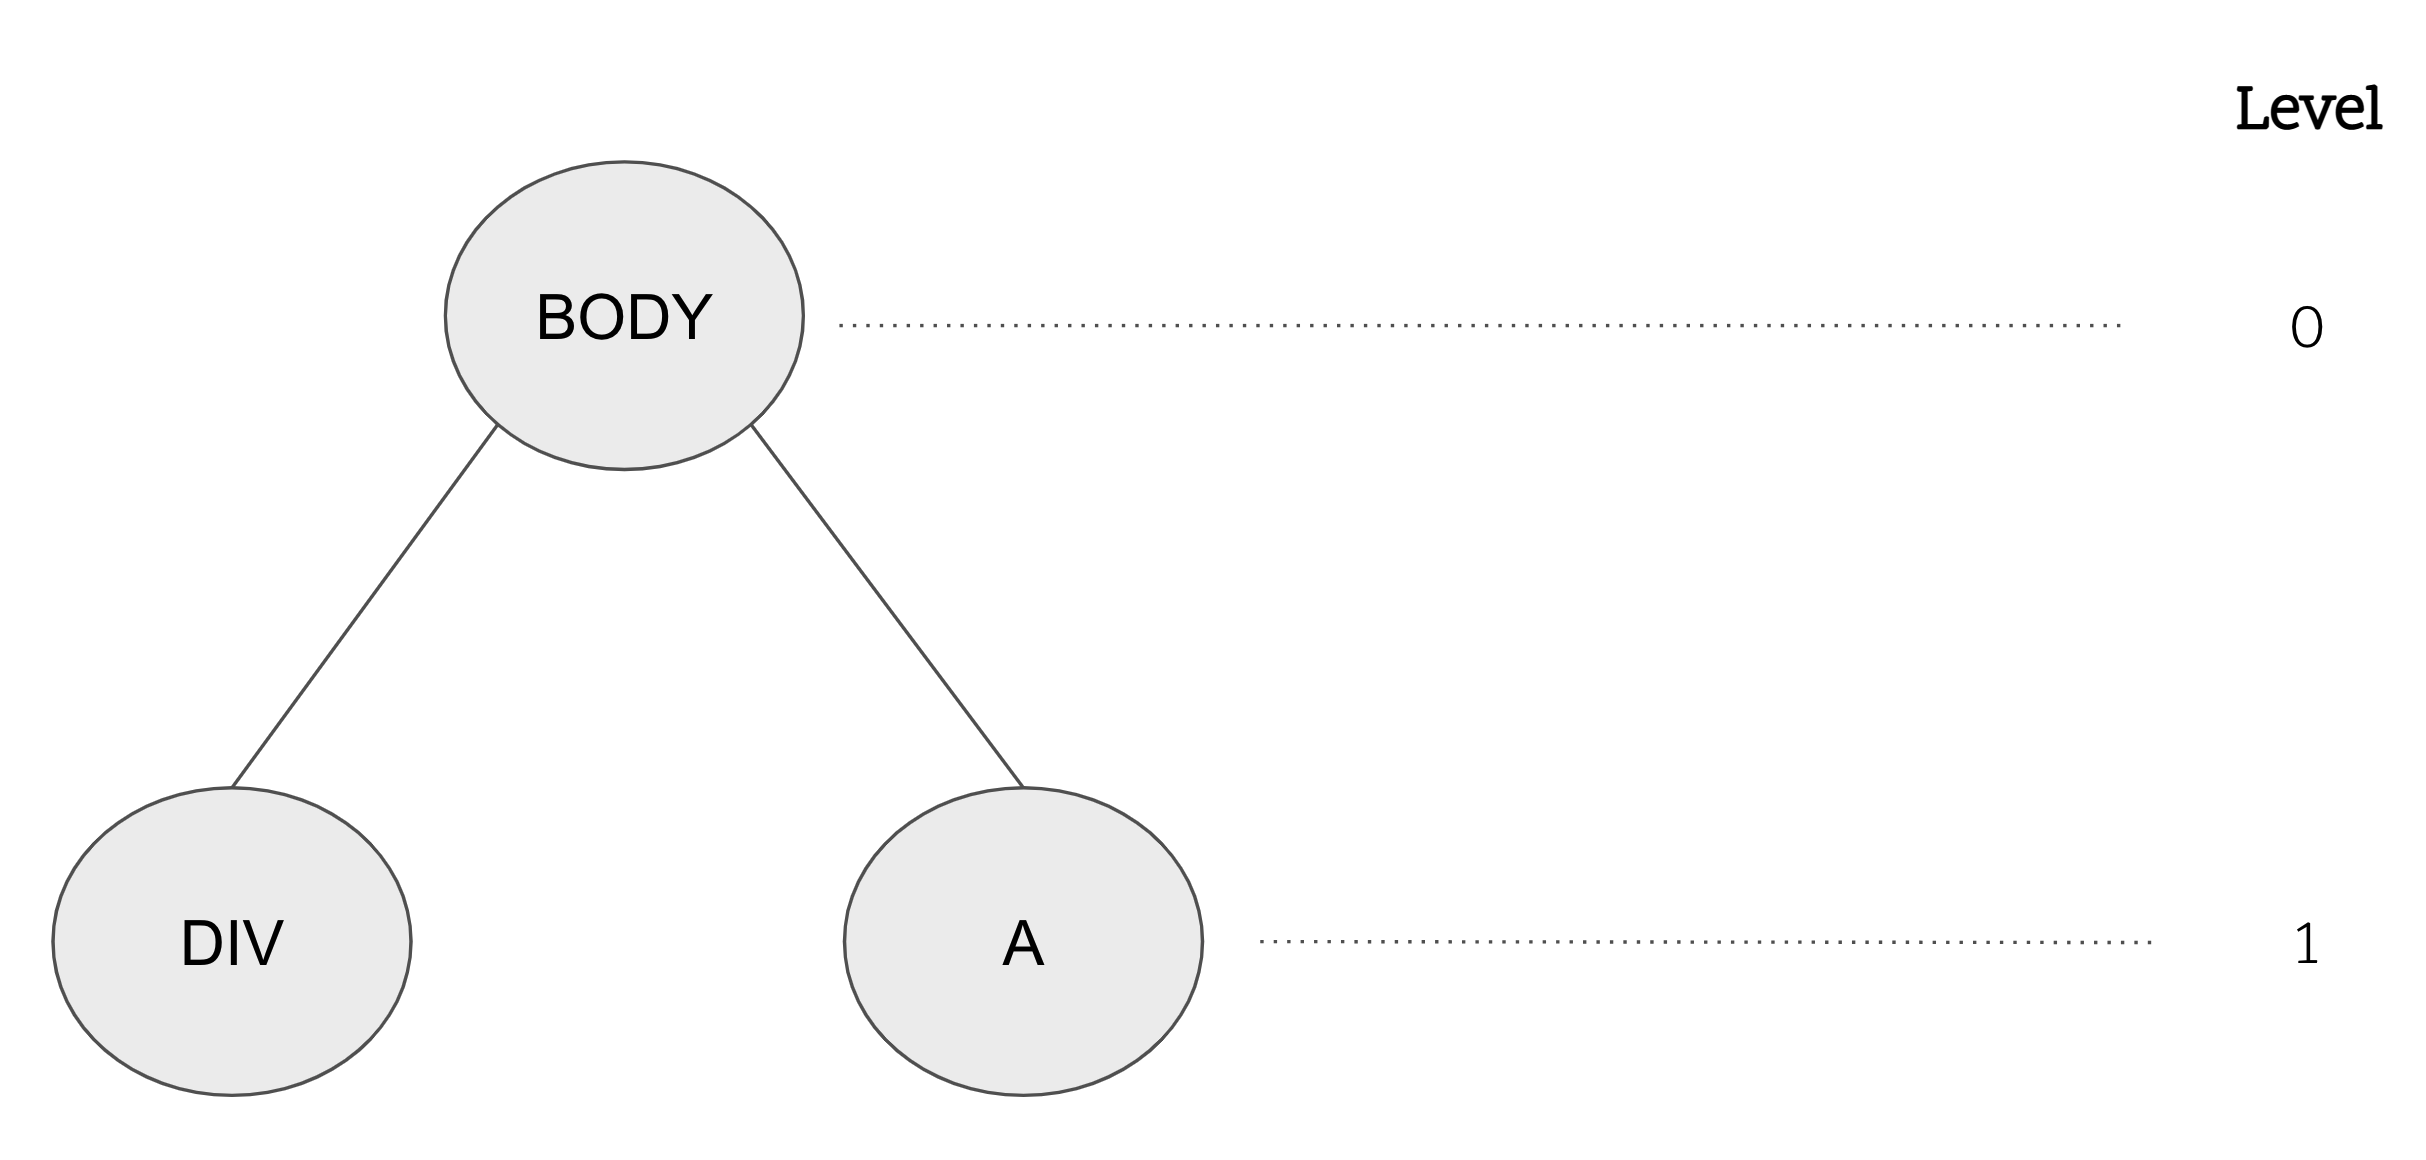



In [ ]:
node_levels = np.zeros(test_graph_size, dtype=np.int)

In [ ]:
def get_node_levels(node: dict, level: int = 0):
  global node_levels

  node_levels[node['id']] = level

  for child in node['children']:
    get_node_levels(child, level+1)

Now, let's test this. For `test_graph`, we expect `node_levels` to be:

$$
\begin{pmatrix}
0 & 1 & 1
\end{pmatrix}
$$


In [ ]:
get_node_levels(test_graph['graph'])
node_levels

#### 3.2.3 Tag type

We noticed from the data statistics that the tag type can be key in distinguishing between our two labels: `ad` and `not-ad`.

Now, let's look at how we can get that information and translate it into a format that our model can understand.

Frist, we need to translate each tag to a numeric value. The easiest way to do so would be to simply map each HTML tag to a different integer, like we do in the constant defined below:

In [ ]:
HTML_TAGS_MAPPINGS = {
    'a': 1, 'abbr': 2, 'address': 3, 'area': 4, 'article': 5, 'aside': 6,
    'audio': 7, 'b': 8, 'base': 9, 'bdi': 10, 'bdo': 11, 'blockquote': 12,
    'body': 13, 'br': 14, 'button': 15, 'canvas': 16, 'caption': 17,
    'cite': 18, 'code': 19, 'col': 20, 'colgroup': 21, 'data': 22,
    'datalist': 23, 'dd': 24, 'del': 25, 'details': 26, 'dfn': 27,
    'dialog': 28, 'div': 29, 'dl': 30, 'dt': 31, 'em': 32, 'embed': 33,
    'fieldset': 34, 'figcaption': 35, 'figure': 36, 'footer': 37, 'form': 38,
    'h1': 39, 'h2': 40, 'h3': 41, 'h4': 42, 'h5': 43, 'h6': 44, 'head': 45,
    'header': 46, 'hgroup': 47, 'hr': 48, 'html': 49, 'i': 50, 'iframe': 51,
    'img': 52, 'input': 53, 'ins': 54, 'kbd': 55, 'keygen': 56, 'label': 57,
    'legend': 58, 'li': 59, 'link': 60, 'main': 61, 'map': 62, 'mark': 63,
    'math': 64, 'menu': 65, 'menuitem': 66, 'meta': 67, 'meter': 68,
    'nav': 69, 'noscript': 70, 'object': 71, 'ol': 72, 'optgroup': 73,
    'option': 74, 'output': 75, 'p': 76, 'param': 77, 'picture': 78,
    'pre': 79, 'progress': 80, 'q': 81, 'rb': 82, 'rp': 83, 'rt': 84,
    'rtc': 85, 'ruby': 86, 's': 87, 'samp': 88, 'script': 89, 'section': 90,
    'select': 91, 'slot': 92, 'small': 93, 'source': 94, 'span': 95,
    'strong': 96, 'style': 97, 'sub': 98, 'summary': 99, 'sup': 100,
    'svg': 101, 'table': 102, 'tbody': 103, 'td': 104, 'template': 105,
    'textarea': 106, 'tfoot': 107, 'th': 108, 'thead': 109, 'time': 110,
    'title': 111, 'tr': 112, 'track': 113, 'u': 114, 'ul': 115,
    'var': 116, 'video': 117, 'wbr': 118,
}

Now, let's write a function that gets a graph as input and returns the resulting tag-id vector.

In [ ]:
tags_vector = np.zeros(test_graph_size, dtype=np.int)

In [ ]:
def get_tag_vector(node: dict):
  # TODO: Write the logic that
  # stores the appropriate values 
  # in `tags_vector`
  pass

Now, let's test this. For `test_graph`, we expect `tags_vector` to be:

$$
\begin{pmatrix}
13 & 29 & 1
\end{pmatrix}
$$

In [ ]:
get_tag_vector(test_graph['graph'])
tags_vector


---

If we take a closer look at this, we can notice that `tag type` is a *categorical feature*. One other way to represent categorical features is by using **[one-hot encoding](https://en.wikipedia.org/wiki/One-hot)**.

This allow us to make each category equidistant to the others, so in other words, just as important as the other categories.


Let's look at how we can adapt the function above to support this

In [ ]:
tags_vector_one_hot = np.array([np.zeros(len(HTML_TAGS_MAPPINGS)) for _ in range(test_graph_size)])

In [ ]:
def get_tags_vector_one_hot(node: dict):
  # TODO: Write the appropriate logic
  # to get the expected output in `tags_vector_one_hot`
  pass

For `test_graph`, we expect to get something that looks like this:

$$
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & ... & 0 & ... & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & ... & 1 & ... & 0 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & ... & 0 & ... & 0
\end{pmatrix}
$$

In [ ]:
get_tags_vector_one_hot(test_graph['graph'])
tags_vector_one_hot

#### 3.2.4 Source information

As you might know, there are some HTML tags that have sources associated with them, using the `src` attribute.

This could provide crucial information, since the source can hint at an `ad` node.

Now, let's look at how we can actually convert this information into something that the model can understand and process. 

The first thing that comes to mind is a basic NLP technique that makes use of **[tokenizers](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization)** to encode the source url into a numeric vector.

First, we need to define an alphabet of symbols that our tokenizer will use when converting the url.

In [ ]:
ACCEPTED_URL_CHRS = r'abcdefghijklmnopqrstuvwxyz1234567890:;/?!=+.,()[]-`*_\|~'

And now, to actually define our tokenizer

In [ ]:
import tensorflow.keras as keras
import numpy as np

tokenizer = keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters=None,
    oov_token=-1,
)
tokenizer.fit_on_texts(ACCEPTED_URL_CHRS)

And test it out against a simple url, such as `https://www.eyeo.com`.
For this url, we expect the resulting vector to be:
$$
\begin{pmatrix}
9 & 21 & 21 & 17 & 20 & 38 & 40 & 40 & 24 & 24 & 24 & 45 & 6 & 26 & 6 & 16 & 45 & 4 & 16 & 14
\end{pmatrix}
$$

In [ ]:
def get_tokenised_sequence(url: str) -> np.array:
  result = tokenizer.texts_to_sequences(url)
  return np.matrix(result).A1

In [ ]:
get_tokenised_sequence('https://www.eyeo.com')

Now, let's see how we can apply this to the `src` attributes we are working with.

First of all, we need to keep in mind the fact that, for the purpose of the models we are using, all of our feature vectors have to be the same size. But not all of the URLs are the same size, so we need to pad/ cut them off at a specific length, say 100 characters

In [ ]:
CUTOFF_SIZE = 100

Now, we need to change the `get_tokenised_sequence` function above so that it also handles padding.

In [ ]:
def get_tokenised_sequence(url: str, cutoff: int = -1) -> np.array:
  result = tokenizer.texts_to_sequences(url)
  if cutoff != -1:
    result = keras.preprocessing.sequence.pad_sequences(
        [result],
        maxlen=cutoff,
        padding='post',
    )
  return np.matrix(result).A1

In [ ]:
get_tokenised_sequence('https://www.eyeo.com', CUTOFF_SIZE)

In [ ]:
src_sequences = [np.zeros(CUTOFF_SIZE) for _ in range(test_graph_size)]

In [ ]:
def src_to_sequences(node: dict):
  # TODO: Write the logic to tokenise the sequences of the nodes,
  # If theere are any. If not, simply have a vector of `0`s instead.
  pass

The expected result for `test_graph` should be:

$$
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & ... & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & ... & 0 \\
24 & 24 & 24 & 45 & 20 & 16 & 14 & 16 & 14 & 6 & 51 & 24 & 6 & 3 & ... & 0 \\
\end{pmatrix}
$$

In [ ]:
import urllib.parse as urlparse

In [ ]:
src_to_sequences(test_graph['graph'])
src_sequences = np.array(src_sequences)
src_sequences



---





Now, we can take a look at some more information that we can get from these sources.

Some useful meta-features related to this would be:


* Whether the node as a source or not. 
* Whether that source is a url or not.
* Whether the source is 3rd party or not.




The simplest way to encode this would be via a 3-dimensional binary vector that looks like this:

$$
\begin{pmatrix}
<has\space source>, <is \space url>, <is \space 3^{rd} \space party>
\end{pmatrix}
$$

In [ ]:
sources_meta_vector = np.array([np.zeros(3) for _ in range(test_graph_size)], dtype=np.int)

In [ ]:
def get_sources_meta_vector(node: dict, domain: str):
  if 'src' in node['attributes']:
    source = node['attributes']['src']
    sources_meta_vector[node['id']][0] = 1

    # Checking if the source is an url
    sources_meta_vector[node['id']][1] = int(source.startswith('http'))

    # Cheching if it is 3rd party or not
    netloc = urlparse.urlparse(source).netloc
    sources_meta_vector[node['id']][2] = int(domain not in netloc)

  for child in node['children']:
    get_sources_meta_vector(child, domain) 

For `test_graph`, we expect the output to be:

$$
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{pmatrix}
$$

In [ ]:
domain = urlparse.urlparse(test_graph['url']).netloc
get_sources_meta_vector(test_graph['graph'], domain)
sources_meta_vector

#### 3.2.5 Display information

Another useful information about HTML elements is their `display` value, which can be one of: `none`, `inline`, `block`, `inline-block`, `inherit`.



We are working again with categorical features, so we'll make use of one-hot vectors once again.

In [ ]:
DISPLAY_ATTR_MAP = {'none': 1, 'inline': 2, 'block': 3, 'inline-block': 4,
                    'inherit': 5}
ONE_HOT_DISPLAY_LEN = len(set(DISPLAY_ATTR_MAP.values()))

In [ ]:
display_vectors = np.array([np.zeros(ONE_HOT_DISPLAY_LEN) for _ in range(test_graph_size)])

In [ ]:
def get_display_vectors(node: dict):
  if 'display' in node['attributes']:
    display_value = node['attributes']['display'].lower()
    node_id = node['id']
    attr_idx = DISPLAY_ATTR_MAP.get(display_value, None)

    if attr_idx:
      display_vectors[node_id][attr_idx - 1] = 1
  
  for child in node['children']:
    get_display_vectors(child)

For `test_graph` we expect the output to be:

$$
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
\end{pmatrix}
$$

In [ ]:
get_display_vectors(test_graph['graph'])
display_vectors

### 3.3 Extracting labels

Labels also have to be in a numeric format.

For each node, we will generate a two dimensional vector:

Ads are represented by the following vector:
$$
\begin{pmatrix}
0 & 1
\end{pmatrix}
$$

while regular nodes are:
$$
\begin{pmatrix}
1 & 0
\end{pmatrix}
$$

In [ ]:
VECTOR_ADS = np.array([0, 1])
VECTOR_NOT_ADS = np.array([1, 0])

In [ ]:
labels = [None for _ in range(test_graph_size)]

In [ ]:
def get_labels(node: dict):
  global labels
  node_id = node['id']
  labels[node_id] = VECTOR_NOT_ADS
  if node['ad']:
    labels[node_id] = VECTOR_ADS

  for child in node['children']:
    get_labels(child)

For `test_graph` we expect the result to be:

$$
\begin{pmatrix}
1 & 0 \\
0 & 1 \\
1 & 0
\end{pmatrix}
$$

In [ ]:
get_labels(test_graph['graph'])
labels = np.array(labels)
labels